In [57]:
import numpy as np
import pickle
import os
import pandas as pd
import re
import random
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models    import load_model
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import pickle

In [45]:
base_dir   = r".\Dataset_100x5"
csv_path   = os.path.join(base_dir, "labels.csv")
IMG_H, IMG_W, BATCH = 224, 224, 32
SEED       = 42

In [46]:
dataset_name   = os.path.basename(base_dir)
prefix_pattern = rf'^{re.escape(dataset_name)}\./'

df = pd.read_csv(csv_path)

df['filepath'] = df['filepath'].str.replace('\\', '/', regex=False)
df['filepath'] = df['filepath'].str.replace(prefix_pattern, '', regex=True)

In [47]:
df

,filepath,label
0,original/000000021147.jpg,Original
1,salt_pepper/000000021147.jpg,Salt & Pepper
2,gaussian/000000021147.jpg,Gaussian
3,uniform/000000021147.jpg,Uniform
4,erlang/000000021147.jpg,Erlang
...,...,...
495,original/000000581081.jpg,Original
496,salt_pepper/000000581081.jpg,Salt & Pepper
497,gaussian/000000581081.jpg,Gaussian
498,uniform/000000581081.jpg,Uniform


In [48]:
import tensorflow as tf

# 1) Lista le GPU disponibili
gpus = tf.config.list_physical_devices('GPU')
print("GPU disponibili:", gpus)

# 2) Se ne trovi almeno una, abilita il memory growth
if gpus:
    try:
        # imposta il memory growth per evitare che TF occupi tutta la VRAM
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth abilitato per le GPU.")
    except RuntimeError as e:
        print("Errore nel configurare la GPU:", e)
else:
    print("Nessuna GPU trovata, TF userà la CPU.")


GPU disponibili: []
Nessuna GPU trovata, TF userà la CPU.


In [49]:
# Split stratificati (stessi esempi per classe)

# 70-15-15 training-validation-test split

# Splitto tutto in training e "temp"
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=SEED)

# Splitto temp in validation e test
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=SEED)

print(f"Train: {len(train_df)/len(df)*100:.1f}%  |  Val: {len(val_df)/len(df)*100:.1f}%  |  Test: {len(test_df)/len(df)*100:.1f}%")

Train: 70.0%  |  Val: 15.0%  |  Test: 15.0%


In [50]:
# Preprocessing: rescaling, resizing, shuffling, one hot encoding

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_df, directory=base_dir,
    x_col="filepath", y_col="label", # colonne di df_train
    target_size=(IMG_H, IMG_W), # da settare bene
    batch_size=BATCH,
    class_mode="categorical", # voglio fare ohe
    shuffle=True,
    seed=SEED
)
val_gen = datagen.flow_from_dataframe(
    val_df, directory=base_dir,
    x_col="filepath", y_col="label",
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)
test_gen = datagen.flow_from_dataframe(
    test_df, directory=base_dir,
    x_col="filepath", y_col="label",
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)

train_gen.class_indices

Found 350 validated image filenames belonging to 5 classes.
Found 75 validated image filenames belonging to 5 classes.
Found 75 validated image filenames belonging to 5 classes.


{'Erlang': 0, 'Gaussian': 1, 'Original': 2, 'Salt & Pepper': 3, 'Uniform': 4}

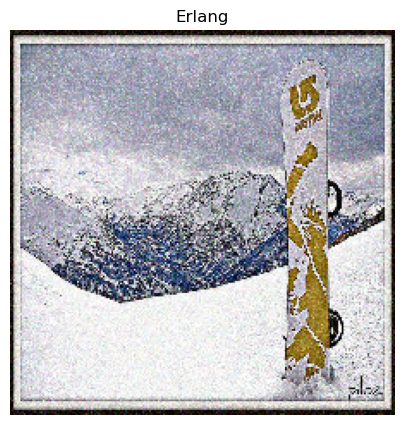

In [53]:
def plot_image(generator):
    """
    Estrae un'immagine random dal DirectoryIterator `generator`
    e la plotta con la sua label.
    """
    # 1) Scelgo un indice casuale tra 0 e generator.samples-1
    idx = random.randint(0, generator.samples - 1)
    
    # 2) Recupero il path assoluto dell'immagine
    img_path = generator.filepaths[idx]
    
    # 3) Carico e ridimensiono l'immagine secondo target_size del generatore
    img = load_img(img_path, target_size=generator.target_size)
    img_arr = img_to_array(img) / 255.0   # normalizzo [0,1]
    
    # 4) Trovo la label corrispondente
    class_idx = generator.classes[idx]
    inv_map = {v: k for k, v in generator.class_indices.items()}
    label = inv_map[class_idx]
    
    # 5) Plotto
    plt.figure(figsize=(5,5))
    plt.imshow(img_arr)
    plt.title(label)
    plt.axis('off')
    plt.show()

plot_image(train_gen)

In [58]:
model = models.Sequential()
model.add(layers.Input(shape=(IMG_H, IMG_W, 3)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(train_gen.class_indices), activation='softmax'))

In [59]:
# Compilazione del modello
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model.save('final_model.h5')

In [ ]:
best_model = load_model('best_model.h5')

In [62]:
es = EarlyStopping(
    monitor='val_loss',
    patience=5, # mi fermo se per 5 epochs non miglioro
    restore_best_weights=True # ripristino pesi migliori (prima di overfittare)
)

mc = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss',
    save_best_only=True # salvo solo il modello con val_loss migliore
)

In [63]:
# Training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[es, mc]
)

c:\Users\tomma\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.2035 - loss: 1.7132

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 578ms/step - accuracy: 0.2032 - loss: 1.7108 - val_accuracy: 0.2267 - val_loss: 1.5979
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.2491 - loss: 1.5956

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step - accuracy: 0.2483 - loss: 1.5951 - val_accuracy: 0.2000 - val_loss: 1.5783
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.2265 - loss: 1.5664

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - accuracy: 0.2291 - loss: 1.5655 - val_accuracy: 0.2667 - val_loss: 1.5524
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.3491 - loss: 1.5033

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.3471 - loss: 1.5033 - val_accuracy: 0.3067 - val_loss: 1.5276
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.3718 - loss: 1.4539

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.3682 - loss: 1.4563 - val_accuracy: 0.3067 - val_loss: 1.5012
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.3246 - loss: 1.4481

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.3244 - loss: 1.4476 - val_accuracy: 0.2800 - val_loss: 1.4954
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.3871 - loss: 1.4165

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step - accuracy: 0.3875 - loss: 1.4147 - val_accuracy: 0.3333 - val_loss: 1.4664
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step - accuracy: 0.4436 - loss: 1.3565 - val_accuracy: 0.2933 - val_loss: 1.4821
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.4292 - loss: 1.3382

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step - accuracy: 0.4289 - loss: 1.3385 - val_accuracy: 0.2933 - val_loss: 1.4476
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.4346 - loss: 1.2956

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.4346 - loss: 1.2956 - val_accuracy: 0.3333 - val_loss: 1.4447
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 0.4561 - loss: 1.2755 - val_accuracy: 0.3333 - val_loss: 1.4782
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.4043 - loss: 1.2877

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.4046 - loss: 1.2877 - val_accuracy: 0.3600 - val_loss: 1.4044
Epoch 13/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - accuracy: 0.4741 - loss: 1.2635 - val_accuracy: 0.2800 - val_loss: 1.4323
Epoch 14/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - accuracy: 0.4805 - loss: 1.2421 - val_accuracy: 0.3200 - val_loss: 1.4433
Epoch 15/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.5165 - loss: 1.1714

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step - accuracy: 0.5137 - loss: 1.1735 - val_accuracy: 0.3600 - val_loss: 1.4025
Epoch 16/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.5457 - loss: 1.1481

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - accuracy: 0.5447 - loss: 1.1483 - val_accuracy: 0.3200 - val_loss: 1.3953
Epoch 17/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.4512 - loss: 1.1837

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 0.4562 - loss: 1.1781 - val_accuracy: 0.3200 - val_loss: 1.3594
Epoch 18/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5127 - loss: 1.1224

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - accuracy: 0.5150 - loss: 1.1197 - val_accuracy: 0.3867 - val_loss: 1.3572
Epoch 19/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5422 - loss: 1.0573

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - accuracy: 0.5427 - loss: 1.0576 - val_accuracy: 0.3600 - val_loss: 1.3226
Epoch 20/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - accuracy: 0.5644 - loss: 1.0118 - val_accuracy: 0.3733 - val_loss: 1.3649
Epoch 21/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - accuracy: 0.5797 - loss: 0.9845 - val_accuracy: 0.3467 - val_loss: 1.3409
Epoch 22/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - accuracy: 0.6017 - loss: 0.9747 - val_accuracy: 0.3067 - val_loss: 1.3827
Epoch 23/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5661 - loss: 0.9730

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - accuracy: 0.5675 - loss: 0.9728 - val_accuracy: 0.3467 - val_loss: 1.3173
Epoch 24/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - accuracy: 0.6491 - loss: 0.9136 - val_accuracy: 0.3600 - val_loss: 1.3962
Epoch 25/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - accuracy: 0.5761 - loss: 0.9167 - val_accuracy: 0.3600 - val_loss: 1.3187
Epoch 26/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.6448 - loss: 0.8671

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - accuracy: 0.6429 - loss: 0.8681 - val_accuracy: 0.3867 - val_loss: 1.2995
Epoch 27/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step - accuracy: 0.6421 - loss: 0.8089 - val_accuracy: 0.3733 - val_loss: 1.3157
Epoch 28/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - accuracy: 0.6615 - loss: 0.8825 - val_accuracy: 0.3600 - val_loss: 1.3241
Epoch 29/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.6375 - loss: 0.8480

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - accuracy: 0.6377 - loss: 0.8466 - val_accuracy: 0.4133 - val_loss: 1.2980
Epoch 30/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - accuracy: 0.6186 - loss: 0.8690 - val_accuracy: 0.3467 - val_loss: 1.2990


In [ ]:
model = load_model("/content/drive/MyDrive/Datasets/CatsDogs/cnn.keras")

In [ ]:
test_loss, test_acc = model.evaluate(test_gen) # CAZZO (41% accuracy)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.4137 - loss: 1.2385


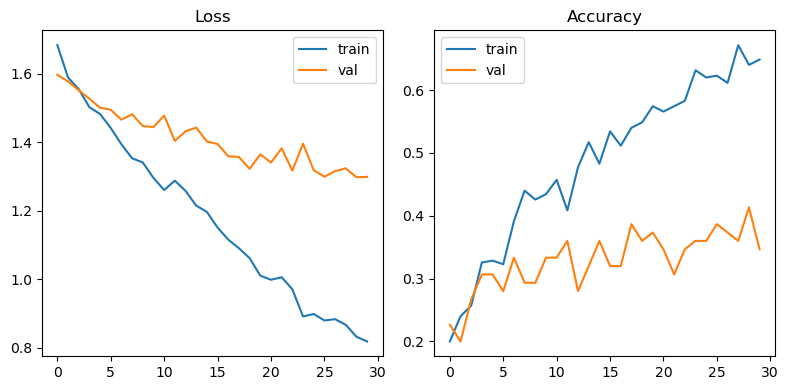

In [65]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizzazione delle immagini (da 0-255 a 0-1)
x_train = x_train / 255.0
x_test = x_test / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [42]:
model = tf.keras.models.Sequential()
model.add(Flatten(input_shape=(28,28)))    # flattens the 28x28 images into arrays of 784 pixels
model.add(Dense(128, activation='relu'))   # 1st hidden layer
model.add(Dense(128, activation='relu'))   # 2nd hidden layer
model.add(Dense(10, activation='softmax')) # output layer

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\tomma\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
model.fit(x_train, y_train, epochs=4) #99.79%, 0.0070 loss

Epoch 1/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8823 - loss: 0.4054
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9700 - loss: 0.0983
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9783 - loss: 0.0677
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9850 - loss: 0.0484


In [53]:
predictions = model.predict(x_test)
y_pred = [np.argmax(prediction) for prediction in predictions]

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
